Alpha:  0.777464814756
Minimum Counts with Impurity:  70.4000873987
Minimum Counts with EIT:  90.5508340216
Rejection ratio:  0.5762
4.27484096498


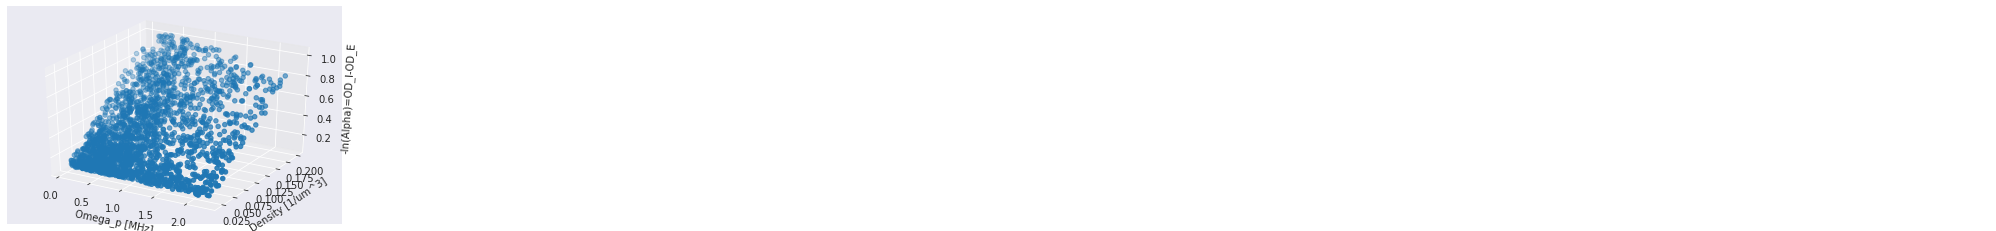

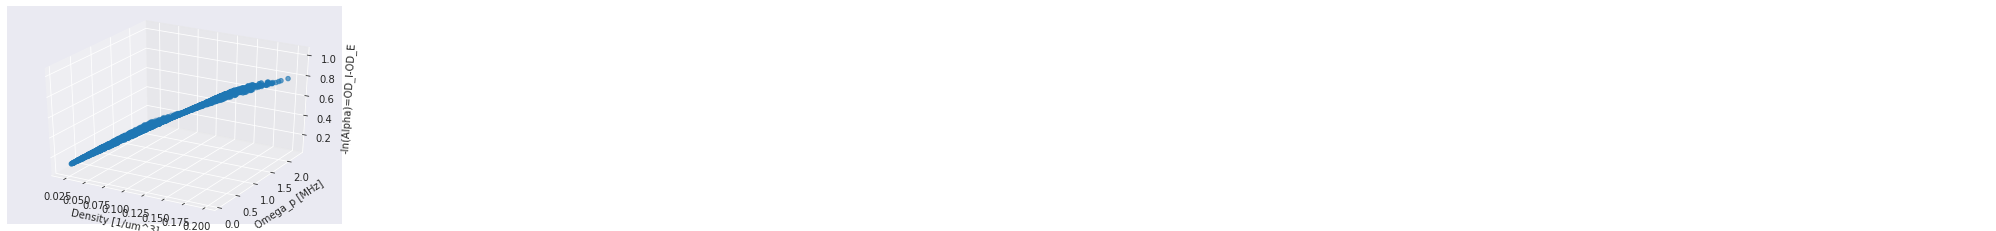

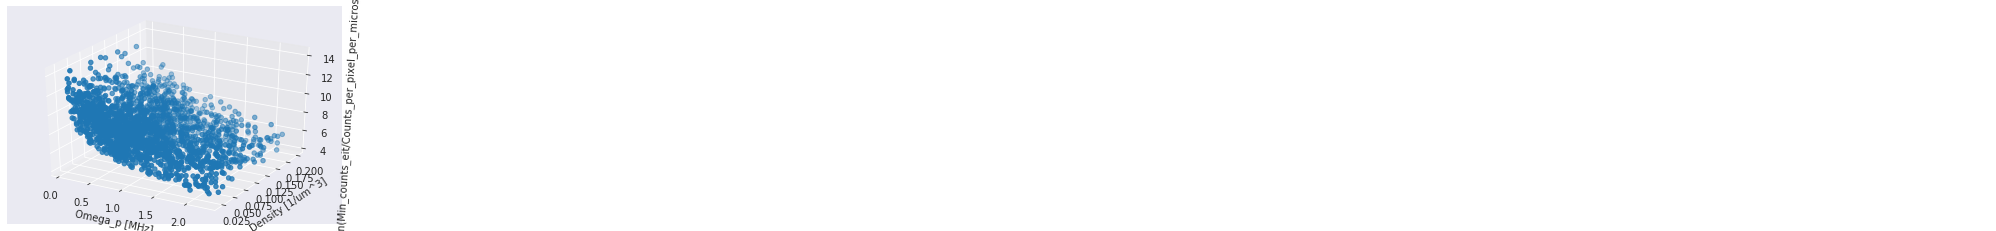

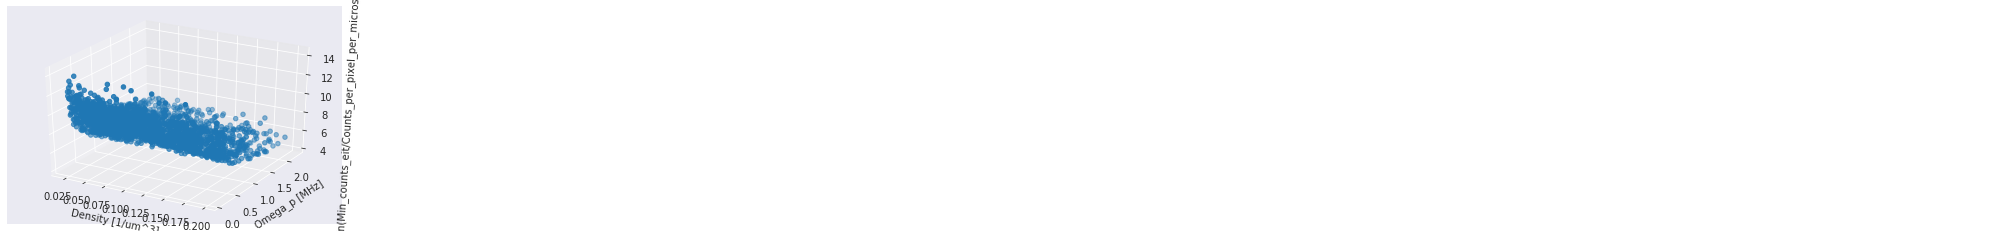

In [431]:
import pyfits
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
import numpy as np
import pylab as plt
import rydlab
import pandas as pd
import os
import copy
from lmfit import Model
from lmfit.models import LorentzianModel
from lmfit.models import ExponentialModel
from lmfit.models import ConstantModel
from lmfit import Parameters, minimize, report_fit, Model
from matplotlib.colors import LinearSegmentedColormap, to_rgb
import seaborn as sns
sns.set_style("dark")
sns.set_style("darkgrid")
import matplotlib as mpl
import scipy.integrate as integrate
import scipy.special as special
from mpl_toolkits.mplot3d import Axes3D

#Parameters in MHz
Omega_p=0.5
Omega_c=2.5
gamma_eg=0.2
gamma_gr=0.001
Gamma_e=6.01
C_3=10000
C_6=200000


cross_section=0.78*0.78 #um^2
n_0=0.5*10**(-1) #1/um^3 = 10^12 1/cm^3 = 10^18 1/m^3
sigma_z=60 #um

N_i=1 #number of impuritíes
sigma_r=4 #read noise


class alphamodel():
    def __init__(self,Omega_p,Omega_c,gamma_eg,gamma_gr,Gamma_e,cross_section,n_0,sigma_z,sigma_r,C_3,C_6,N_i):
        
        self.Omega_p=Omega_p
        self.Omega_c=Omega_c
        self.gamma_eg=gamma_eg
        self.gamma_gr=gamma_gr
        self.Gamma_e=Gamma_e
        self.cross_section=cross_section
        self.n_0=n_0
        self.N_i=N_i
        self.sigma_z=sigma_z
        self.C_3=C_3
        self.C_6=C_6
        self.Q_E=0.44
        
        self.n_counts=(self.Omega_p/2.4)**2 #in counts per pixel per microsecond
        self.rho_0=self.Omega_p**2/self.Omega_c**2   
        
        self.R_3=( 2*self.C_3*self.gamma_eg / (self.Omega_c**2+self.gamma_eg*self.gamma_gr) )**(1/3)
        self.R_6=( 2*self.C_6*self.gamma_eg / (self.Omega_c**2+self.gamma_eg*self.gamma_gr) )**(1/6)
        
        self.V_bl_3=4/3*np.pi*self.R_3**3
        self.V_bl_6=4/3*np.pi*self.R_6**3
        
        self.z_grid=np.linspace(-150,150,300)
        
        self.ground_state_density=self.n_0*np.exp(-0.5*(self.z_grid/self.sigma_z)**2)
        self.impurity_density=self.N_i/(self.R_3*np.sqrt(2*np.pi))*np.exp(-0.5*(self.z_grid/self.R_3)**2)
        
        self.f_bl=self.rho_0*self.V_bl_6*self.ground_state_density
        self.f_ir=1-(1/(1+self.impurity_density*self.V_bl_3))
        
        self.N_bl_3=self.V_bl_3*self.ground_state_density
        self.N_bl_6=self.V_bl_6*self.ground_state_density
        
        self.chi_3_lvl=self.Gamma_e**2/(self.Gamma_e**2+self.Omega_c**2*self.Gamma_e/self.gamma_gr+2*self.Omega_p**2)
        self.chi_2_lvl=self.Gamma_e/(self.Gamma_e**2+2*self.Omega_p**2)
        
        self.integrand=self.cross_section*self.ground_state_density*self.f_ir*self.chi_2_lvl*(self.chi_3_lvl/self.chi_2_lvl*self.f_bl/(1+self.f_bl)-1)
        self.alpha=np.e**(integrate.simps(self.integrand, self.z_grid))

        self.min_counts_e=0.5*(np.sqrt(16*sigma_r**2/(1-self.alpha)**2+((self.alpha+3)/(1-self.alpha)**2)**2)+(self.alpha+3)/(1-self.alpha)**2)
        self.min_counts_i=self.alpha*self.min_counts_e
        
        self.min_counts_raw=self.min_counts_e/self.Q_E*np.e**(integrate.simps(self.ground_state_density*self.chi_3_lvl*self.f_bl/(1+self.f_bl)))
        
        self.step_count=0
        self.trial_value=0
        self.upper_bound=self.Omega_c
        self.lower_bound=0.05
        self.upper_bound_n_0=2*10**(-1)
        self.lower_bound_n_0=2*10**(-2)
        self.step_size=0.1
        self.current_value=self.Omega_p
        self.rejected_values=0
        
        self.Omega_p_list=[]
        self.alpha_list=[]
        self.n_0_list=[]
        self.min_counts_i_list=[]
        self.min_counts_e_list=[]
        self.n_counts_list=[]
        self.min_counts_over_n_counts=[]
        
    def update(self):
        self.step_count+=1
        new_Omega_p=self.Omega_p+self.step_size*np.random.uniform(-1,1)
        new_n_0=self.n_0*10**(np.random.uniform(-1,1))
    
        if new_Omega_p>self.upper_bound or new_Omega_p<self.lower_bound or new_n_0>self.upper_bound_n_0 or new_n_0<self.lower_bound_n_0:
            self.rejected_values+=1
            self.rejection_ratio=self.rejected_values/self.step_count
            return None
        
        new_ground_state_density=new_n_0*np.exp(-0.5*(self.z_grid/self.sigma_z)**2)
        new_rho_0=new_Omega_p**2/self.Omega_c**2
        new_f_bl=new_rho_0*self.V_bl_6*new_ground_state_density
        new_chi_3_lvl=self.Gamma_e**2/(self.Gamma_e**2+self.Omega_c**2*self.Gamma_e/self.gamma_gr+2*new_Omega_p**2)
        new_chi_2_lvl=self.Gamma_e/(self.Gamma_e**2+2*new_Omega_p**2)        
        new_integrand=self.cross_section*new_ground_state_density*self.f_ir*new_chi_2_lvl*(new_chi_3_lvl/new_chi_2_lvl*new_f_bl/(1+new_f_bl)-1)
        new_alpha=np.e**(integrate.simps(new_integrand, self.z_grid))
        new_min_counts_e=0.5*(np.sqrt(16*sigma_r**2/(1-new_alpha)**2+((new_alpha+3)/(1-new_alpha)**2)**2)+(new_alpha+3)/(1-new_alpha)**2)
        new_min_counts_i=new_alpha*new_min_counts_e
        new_n_counts=(new_Omega_p/2.4)**2
        new_min_counts_raw=self.min_counts_e/self.Q_E*np.e**(integrate.simps(new_ground_state_density*new_chi_3_lvl*new_f_bl/(1+new_f_bl)))

        if self.alpha/new_alpha>1:# and new_min_counts_e/new_n_counts<5000:
            self.n_0=new_n_0
            self.ground_state_density=new_ground_state_density
            self.Omega_p=new_Omega_p
            self.rho_0=new_rho_0
            self.f_bl=new_f_bl
            self.chi_3_lvl=new_chi_3_lvl
            self.chi_2_lvl=new_chi_2_lvl
            self.integrand=new_integrand
            self.alpha=new_alpha
            self.min_counts_e=new_min_counts_e
            self.min_counts_i=new_min_counts_i
            self.n_counts=new_n_counts
            self.min_counts_raw=new_min_counts_raw

            self.Omega_p_list.append(self.Omega_p)
            self.alpha_list.append(-np.log(self.alpha))
            self.n_0_list.append(self.n_0)
            
            self.min_counts_i_list.append(self.min_counts_i)
            self.min_counts_e_list.append(self.min_counts_e)
            self.n_counts_list.append(self.n_counts)
            self.min_counts_over_n_counts.append(np.log(self.min_counts_raw/self.n_counts))
            
        elif self.alpha/new_alpha>np.random.uniform(0,1):# and new_min_counts_e/new_n_counts<5000:
            self.n_0=new_n_0
            self.ground_state_density=new_ground_state_density
            self.Omega_p=new_Omega_p
            self.rho_0=new_rho_0
            self.f_bl=new_f_bl
            self.chi_3_lvl=new_chi_3_lvl
            self.chi_2_lvl=new_chi_2_lvl
            self.integrand=new_integrand
            self.alpha=new_alpha
            self.min_counts_e=new_min_counts_e
            self.min_counts_i=new_min_counts_i
            self.n_counts=new_n_counts

            self.Omega_p_list.append(self.Omega_p)
            self.alpha_list.append(-np.log(self.alpha))
            self.n_0_list.append(self.n_0)
            
            self.min_counts_i_list.append(self.min_counts_i)
            self.min_counts_e_list.append(self.min_counts_e)
            self.n_counts_list.append(self.n_counts)
            self.min_counts_over_n_counts.append(np.log(self.min_counts_raw/self.n_counts))
            
        else:
            self.rejected_values+=1
        self.rejection_ratio=self.rejected_values/self.step_count
        
           
        
        
        
            
        #self.a_value_grid=4*self.gamma_eg*(self.Gamma_e*self.gamma_eg+2*self.Omega_p**2)*self.C_6**2*(4/3*self.ground_state_density)**2  
        #self.b_value=(self.Omega_p**2+self.Omega_c**2)*(self.Gamma_e*self.Omega_c**2+self.gamma_eg*self.Omega_p**2) 
        #self.imp=integrate.simps(self.impurity_density, self.z_grid)
    #def f_bl(self,z):
        #Up_to_N=100
        #Nlist=np.linspace(0,Up_to_N-1,Up_to_N-1)
        #blockNmatrix=np.zeros((Up_to_N,len(self.z_grid)))
        #for n in Nlist:
        #    blockNmatrix[n]=n**4*self.b_value/self.a_value_grid*(1+(n-1)*self.rho_0)-1
            
        #print(blockNmatrix[59])
        #for x in range(0,len(self.z_grid)):
        #    print(np.where(np.diff(np.signbit(blockNmatrix[Nlist][x]))))
        #return None#np.where(np.diff(np.signbit(blockNlist)))

    
    
a=alphamodel(Omega_p , Omega_c , gamma_eg , gamma_gr , Gamma_e , cross_section , n_0 , sigma_z , sigma_r , C_3 , C_6 , N_i=1)
print("Alpha: " ,a.alpha)
print("Minimum Counts with Impurity: ", a.min_counts_i)
print("Minimum Counts with EIT: ", a.min_counts_e)

while a.step_count<5000:
    a.update()


#print("Omega_p:",a.Omega_p_list)
#print("Densities:",a.n_0_list)
#print("Alphas:",a.alpha_list)

    
print("Rejection ratio: " ,a.rejection_ratio)

print(np.nanmin(a.min_counts_over_n_counts))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.Omega_p_list, a.n_0_list, a.alpha_list)

ax.set_xlabel('Omega_p [MHz]')
ax.set_ylabel('Density [1/um^3]')
ax.set_zlabel('-ln(Alpha)=OD_I-OD_E')

plt.show()    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.n_0_list,a.Omega_p_list, a.alpha_list)

ax.set_xlabel('Density [1/um^3]')
ax.set_ylabel('Omega_p [MHz]')
ax.set_zlabel('-ln(Alpha)=OD_I-OD_E')

plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.Omega_p_list,a.n_0_list,a.min_counts_over_n_counts,cmap='afmhot')


ax.set_xlabel('Omega_p [MHz]')
ax.set_ylabel('Density [1/um^3]')
ax.set_zlabel('ln(Min_counts_eit/Counts_per_pixel_per_microsecond)')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.n_0_list,a.Omega_p_list, a.min_counts_over_n_counts,cmap='afmhot')

ax.set_xlabel('Density [1/um^3]')
ax.set_ylabel('Omega_p [MHz]')
ax.set_zlabel('ln(Min_counts_eit/Counts_per_pixel_per_microsecond)')

plt.show()





#plt.plot(a.z_grid,a.f_bl(a.z_grid))


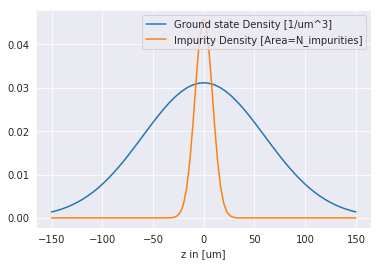

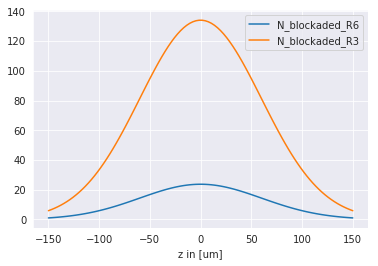

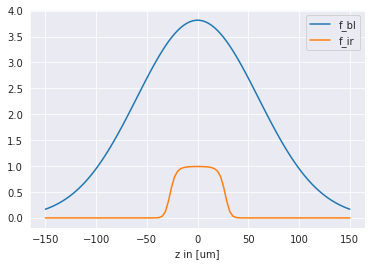

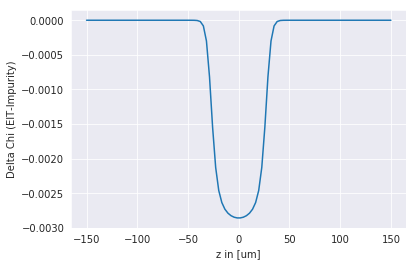

Alpha:  0.86447205688
Minimum Counts with Impurity:  195.217800288
Minimum Counts with EIT:  225.823146896


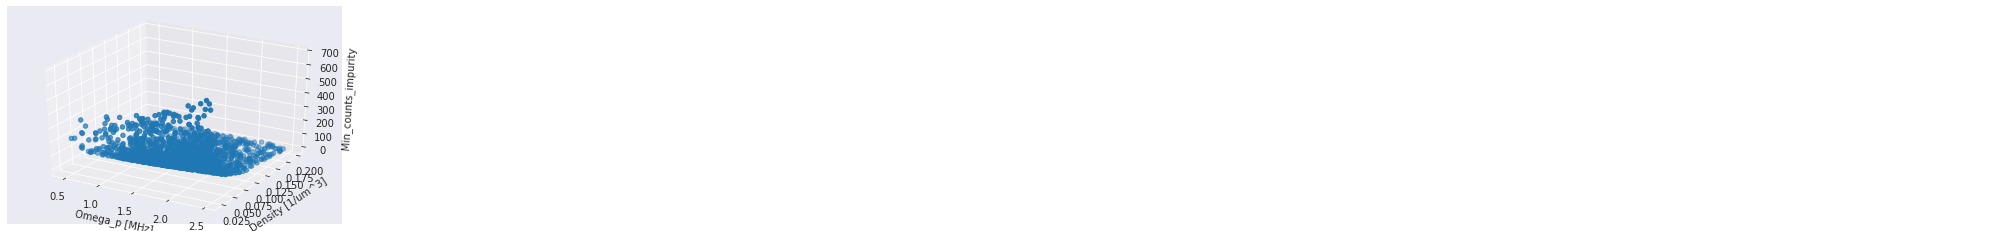

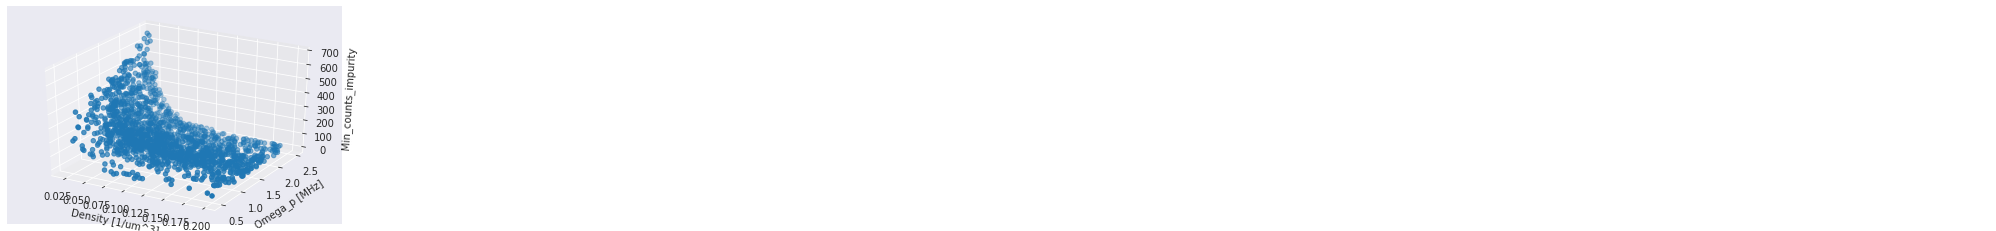

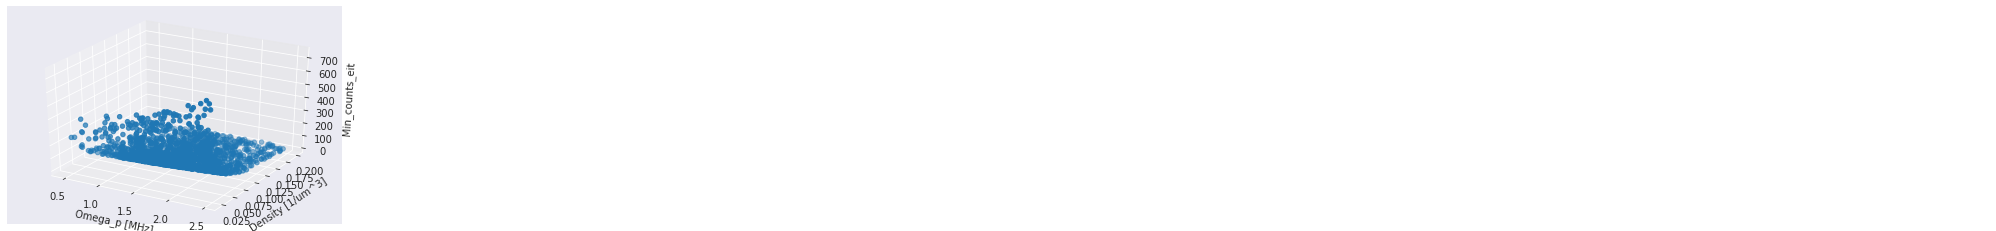

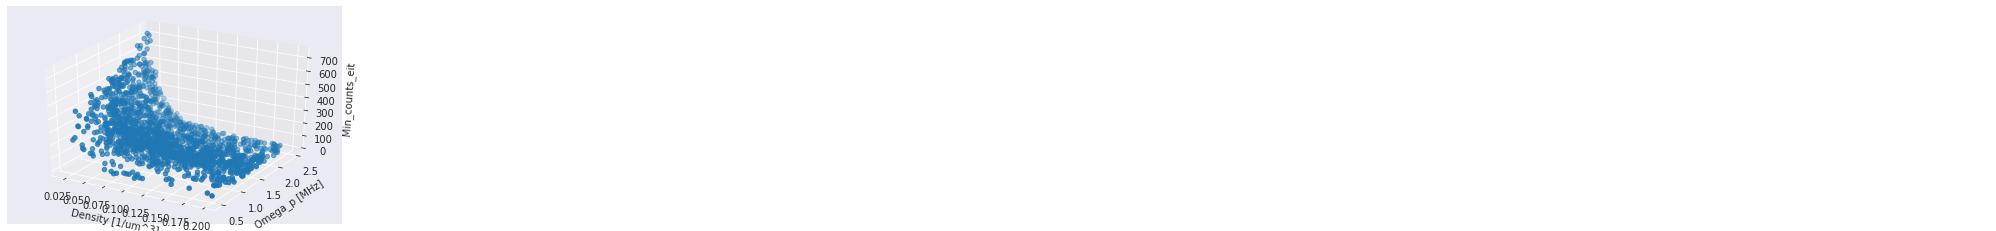

In [428]:
plt.plot(a.z_grid,a.ground_state_density,label='Ground state Density [1/um^3]')
plt.plot(a.z_grid,a.impurity_density,label='Impurity Density [Area=N_impurities]')
plt.legend()
plt.xlabel("z in [um]")
plt.show()

plt.plot(a.z_grid,a.N_bl_6,label='N_blockaded_R6')
plt.plot(a.z_grid,a.N_bl_3,label='N_blockaded_R3')
plt.legend()
plt.xlabel("z in [um]")
plt.show()

plt.plot(a.z_grid,a.f_bl,label='f_bl')
plt.plot(a.z_grid,a.f_ir,label='f_ir')
plt.legend()
plt.xlabel("z in [um]")
plt.show()

plt.plot(a.z_grid,a.integrand)
plt.ylabel("Delta Chi (EIT-Impurity)")
plt.xlabel("z in [um]")
plt.show()


print("Alpha: " ,a.alpha)
print("Minimum Counts with Impurity: ", a.min_counts_i)
print("Minimum Counts with EIT: ", a.min_counts_e)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.Omega_p_list,a.n_0_list,a.min_counts_i_list,cmap='afmhot')

ax.set_xlabel('Omega_p [MHz]')
ax.set_ylabel('Density [1/um^3]')
ax.set_zlabel('Min_counts_impurity')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.n_0_list,a.Omega_p_list, a.min_counts_i_list,cmap='afmhot')


ax.set_xlabel('Density [1/um^3]')
ax.set_ylabel('Omega_p [MHz]')
ax.set_zlabel('Min_counts_impurity')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.Omega_p_list,a.n_0_list,a.min_counts_e_list,cmap='afmhot')


ax.set_xlabel('Omega_p [MHz]')
ax.set_ylabel('Density [1/um^3]')
ax.set_zlabel('Min_counts_eit')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a.n_0_list,a.Omega_p_list, a.min_counts_e_list,cmap='afmhot')


ax.set_xlabel('Density [1/um^3]')
ax.set_ylabel('Omega_p [MHz]')
ax.set_zlabel('Min_counts_eit')

plt.show()

In [468]:
class alphamodel():
    def __init__(self,Omega_p,Omega_c,gamma_eg,gamma_gr,Gamma_e,Q_E,n_0,sigma_z,sigma_r,C_3,C_6,N_i):
        
        self.Omega_p=Omega_p
        self.Omega_c=Omega_c
        self.gamma_eg=gamma_eg
        self.gamma_gr=gamma_gr
        self.Gamma_e=Gamma_e
        self.n_0=n_0
        self.N_i=N_i
        self.sigma_z=sigma_z
        self.sigma_r=sigma_r
        self.C_3=C_3
        self.C_6=C_6
        self.Q_E=Q_E
        self.z_grid=np.linspace(-150,150,300)
        
        self.step_count=0
        self.rejected_values=0
        self.rejection_ratio=1
        self.rejected_values_oob=0
        self.rejection_ratio_oob=1
        
        self.Omega_p_list=[]           
        self.Omega_c_list=[]
        self.alpha_list=[]
        self.n_0_list=[]
        self.min_counts_i_list=[]
        self.min_counts_e_list=[]
        self.n_counts_list=[]
        self.min_counts_over_n_counts=[]
        
    def n_counts(self):
        return (self.Omega_p/2.4)**2 #in counts per pixel per microsecond
    def rho_0(self):
        return self.Omega_p**2/self.Omega_c**2           
    def R_3(self):
        return ( 2*self.C_3*self.gamma_eg / (self.Omega_c**2+self.gamma_eg*self.gamma_gr) )**(1/3)
    def R_6(self):
        return ( 2*self.C_6*self.gamma_eg / (self.Omega_c**2+self.gamma_eg*self.gamma_gr) )**(1/6)
    def V_bl_3(self):
        return 4/3*np.pi*self.R_3()**3
    def V_bl_6(self):
        return 4/3*np.pi*self.R_6()**3
    def ground_state_density(self):
        return self.n_0*np.exp(-0.5*(self.z_grid/self.sigma_z)**2)
    def impurity_density(self):
        return self.N_i/(self.R_3()*np.sqrt(2*np.pi))*np.exp(-0.5*(self.z_grid/self.R_3())**2)
    def f_bl(self):
        return self.rho_0()*self.V_bl_6()*self.ground_state_density()
    def f_ir(self):
        return 1-(1/(1+self.impurity_density()*self.V_bl_3()))
    def N_bl_3(self):
        return self.V_bl_3()*self.ground_state_density()
    def N_bl_6(self):
        return self.V_bl_6()*self.ground_state_density()
    def chi_3_lvl(self):
        return self.Gamma_e**2/(self.Gamma_e**2+self.Omega_c**2*self.Gamma_e/self.gamma_gr+2*self.Omega_p**2)
    def chi_2_lvl(self):
        return self.Gamma_e/(self.Gamma_e**2+2*self.Omega_p**2)
    def integrand(self):
        return cross_section*self.ground_state_density()*self.f_ir()*self.chi_2_lvl()*(self.chi_3_lvl()/self.chi_2_lvl()*self.f_bl()/(1+self.f_bl())-1)
    def alpha(self):
        return np.e**(integrate.simps(self.integrand(), self.z_grid))
    def  min_counts_e(self):
        return 0.5*(np.sqrt(16*self.sigma_r**2/(1-self.alpha())**2+((self.alpha()+3)/(1-self.alpha())**2)**2)+(self.alpha()+3)/(1-self.alpha())**2)
    def min_counts_i(self):
        return self.alpha()*self.min_counts_e()
    def min_counts_raw(self):
        return self.min_counts_e()/self.Q_E*np.e**(integrate.simps(cross_section*self.ground_state_density()*self.chi_3_lvl()*self.f_bl()/(1+self.f_bl())))
        
        
    def update(self):
        
        self.step_count+=1
        #print(self.step_count)
        old_Omega_p=self.Omega_p
        old_Omega_c=self.Omega_c
        old_n_0=self.n_0
        old_alpha=self.alpha()
        self.n_0=self.n_0*2**(np.random.uniform(-0.5,0.5))
        self.Omega_c=self.Omega_c+np.random.uniform(-0.1,0.1)
        self.Omega_p=self.Omega_c*np.random.uniform(0,1)
        #print(old_alpha)
        #print(self.alpha())
        
        if  self.n_0>2*10**(-1) or self.n_0<10**(-5) or self.Omega_c>10*self.Gamma_e or self.Omega_c<0.01:#self.Omega_p>0.9*self.Omega_c or self.Omega_p<self.lower_bound
            #print("Reject, out of bounds")
            self.rejected_values_oob+=1
            self.rejection_ratio_oob=self.rejected_values_oob/self.step_count
            self.Omega_p=old_Omega_p
            self.Omega_c=old_Omega_c
            self.n_0=old_n_0
            return None
        
        elif self.alpha()<old_alpha or self.alpha()<old_alpha*np.random.uniform(0,1):# and new_min_counts_e/new_n_counts<5000:
            #print("Accept")
            self.Omega_p_list.append(self.Omega_p)
            self.Omega_c_list.append(self.Omega_c)
            self.n_0_list.append(self.n_0)
            self.alpha_list.append(-np.log(self.alpha()))
            self.min_counts_i_list.append(self.min_counts_i())
            self.min_counts_e_list.append(self.min_counts_e())
            self.n_counts_list.append(self.n_counts())
            self.min_counts_over_n_counts.append(np.log(self.min_counts_raw()/self.n_counts()))
            return None
          
        else:
            #print("Reject, Alpha is too big")
            self.rejected_values+=1
            self.Omega_p=old_Omega_p
            self.Omega_c=old_Omega_c
            self.n_0=old_n_0
            self.rejection_ratio=self.rejected_values/self.step_count
            return None

Alpha:  0.803441746907
Minimum Counts with Impurity:  90.8633248447
Minimum Counts with EIT:  113.092610876
Rejection ratio:  0.5178
Rejection ratio out of Bounds:  0.47879575915183037
Minimum Number of Counts per pixel per microsecond 46.3736511967


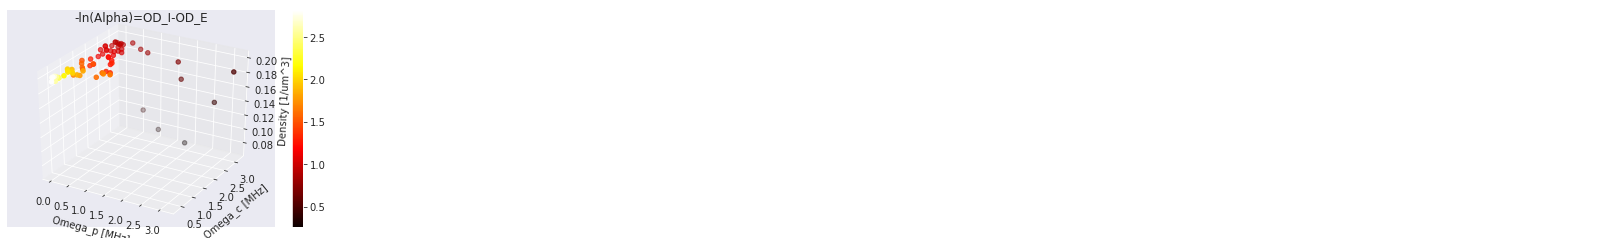

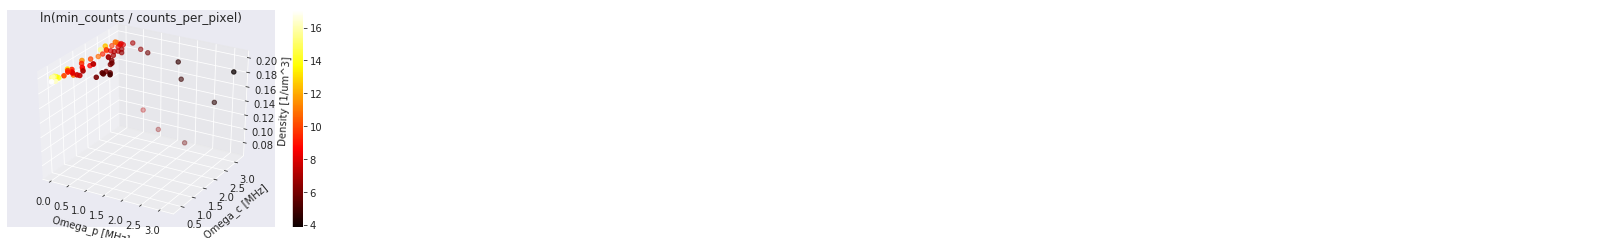

In [470]:
#Parameters in MHz
Omega_p=0.5
Omega_c=3
gamma_eg=0.2
gamma_gr=0.001
Gamma_e=6.01
C_3=10000
C_6=200000
Q_E=0.44

cross_section=0.78*0.78 #um^2
n_0=0.5*10**(-1) #1/um^3 = 10^12 1/cm^3 = 10^18 1/m^3
sigma_z=60 #um

N_i=1 #number of impuritíes
sigma_r=4 #read noise    
    
a=alphamodel(Omega_p , Omega_c , gamma_eg , gamma_gr , Gamma_e ,Q_E, n_0 , sigma_z , sigma_r , C_3 , C_6 , N_i=1)
print("Alpha: " ,a.alpha())
print("Minimum Counts with Impurity: ", a.min_counts_i())
print("Minimum Counts with EIT: ", a.min_counts_e())

while a.step_count<20000:
    a.update()
    
print("Rejection ratio: " ,a.rejection_ratio)
print("Rejection ratio out of Bounds: " ,a.rejection_ratio_oob)

print("Minimum Number of Counts per pixel per microsecond", np.e**np.nanmin(a.min_counts_over_n_counts))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = a.Omega_p_list
y = a.Omega_c_list
z = a.n_0_list
c = a.alpha_list

ax.set_xlabel('Omega_p [MHz]')
ax.set_ylabel('Omega_c [MHz]')
ax.set_zlabel('Density [1/um^3]')
ax.set_title('-ln(Alpha)=OD_I-OD_E')

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = a.Omega_p_list
y = a.Omega_c_list
z = a.n_0_list
c = a.min_counts_over_n_counts

ax.set_xlabel('Omega_p [MHz]')
ax.set_ylabel('Omega_c [MHz]')
ax.set_zlabel('Density [1/um^3]')
ax.set_title('ln(min_counts / counts_per_pixel)')

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()